<a href="https://colab.research.google.com/github/charan1814/Re-identification-in-single-feed/blob/main/re_identification_feed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("hi")

hi


In [2]:
!nvidia-smi

Fri Jun 27 08:30:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install -q gdown inference-gpu supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 22.1 MB/s e

In [10]:
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import supervision as sv
import numpy as np

In [9]:
!pip install supervision -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 6.1 MB/s eta 0:00:00


In [11]:
source_video_path = "/content/15sec_input_720p.mp4"
target_video_path="/content/15sec_output_720p.mp4"
ball_id=0


cap = cv2.VideoCapture(source_video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

video_info=sv.VideoInfo(width=width, height=height, fps=fps)
video_sink=sv.VideoSink(target_video_path,video_info=video_info)
# Load the YOLO model
model_path = "/content/best.pt"
player_detection_model = YOLO(model_path)



elipse_annotator=sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF','#FF1493','#FFD700']),thickness=2)


label_annotator=sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF','#FF1493','#FFD700']),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER)



triangle_annotator=sv.TriangleAnnotator(
    color=sv.Color.from_hex("#FFD700"),
    base=20,height=17)

tracker=sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(source_video_path)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):



        # Perform inference (use .predict or just call the model)
        results = player_detection_model(frame, conf=0.3)[0]

        # Convert to supervision Detections object
        detections = sv.Detections(
            xyxy=results.boxes.xyxy.cpu().numpy(),
            confidence=results.boxes.conf.cpu().numpy(),
            class_id=results.boxes.cls.cpu().numpy().astype(int)
        )

        ball_detection=detections[detections.class_id==ball_id]
        ball_detection.xyxy=sv.pad_boxes(xyxy=ball_detection.xyxy,px=10)
        all_detection=detections[detections.class_id!=ball_id]
        all_detection=all_detection.with_nms(threshold=0.5,class_agnostic=True)
        all_detection.class_id=all_detection.class_id-1
        all_detection=tracker.update_with_detections(all_detection)






        #labeling class and confidence levels
        labels=[
            f"#{tracker_id}"
            for tracker_id in
            all_detection.tracker_id
        ]

        annotated_frame=frame.copy()
        annotated_frame=elipse_annotator.annotate(annotated_frame,all_detection)
        annotated_frame=triangle_annotator.annotate(annotated_frame,ball_detection)
        annotated_frame=label_annotator.annotate(annotated_frame,all_detection,labels=labels)
        # Plot the players in video
        video_sink.write_frame(annotated_frame)


0it [00:00, ?it/s]


0: 384x640 1 ball, 16 players, 2 referees, 66.0ms
Speed: 21.1ms preprocess, 66.0ms inference, 316.2ms postprocess per image at shape (1, 3, 384, 640)


1it [00:07,  7.94s/it]


0: 384x640 18 players, 2 referees, 59.7ms
Speed: 2.1ms preprocess, 59.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


2it [00:08,  3.35s/it]


0: 384x640 1 ball, 16 players, 2 referees, 57.0ms
Speed: 2.9ms preprocess, 57.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 48.7ms
Speed: 3.2ms preprocess, 48.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


4it [00:08,  1.30s/it]


0: 384x640 1 ball, 14 players, 2 referees, 48.7ms
Speed: 2.3ms preprocess, 48.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 2 referees, 37.9ms
Speed: 2.5ms preprocess, 37.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


6it [00:08,  1.39it/s]


0: 384x640 15 players, 2 referees, 37.9ms
Speed: 2.3ms preprocess, 37.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 1 referee, 37.7ms
Speed: 3.4ms preprocess, 37.7ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


8it [00:08,  2.18it/s]


0: 384x640 1 ball, 16 players, 1 referee, 32.9ms
Speed: 4.2ms preprocess, 32.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 2 referees, 33.6ms
Speed: 2.7ms preprocess, 33.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


10it [00:08,  3.14it/s]


0: 384x640 1 ball, 15 players, 2 referees, 33.1ms
Speed: 2.5ms preprocess, 33.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 2 referees, 35.8ms
Speed: 2.2ms preprocess, 35.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


12it [00:08,  4.30it/s]


0: 384x640 1 ball, 13 players, 2 referees, 31.4ms
Speed: 2.4ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 2 referees, 33.1ms
Speed: 2.1ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


14it [00:08,  5.60it/s]


0: 384x640 14 players, 2 referees, 33.1ms
Speed: 2.2ms preprocess, 33.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 players, 2 referees, 32.8ms
Speed: 2.0ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


16it [00:09,  6.99it/s]


0: 384x640 14 players, 2 referees, 33.1ms
Speed: 2.2ms preprocess, 33.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 32.6ms
Speed: 2.0ms preprocess, 32.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


18it [00:09,  8.35it/s]


0: 384x640 15 players, 2 referees, 38.5ms
Speed: 2.2ms preprocess, 38.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 33.6ms
Speed: 2.0ms preprocess, 33.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


20it [00:09,  9.93it/s]


0: 384x640 14 players, 1 referee, 34.3ms
Speed: 2.0ms preprocess, 34.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 4 referees, 34.6ms
Speed: 2.2ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


22it [00:09, 11.48it/s]


0: 384x640 14 players, 3 referees, 33.5ms
Speed: 2.0ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 3 referees, 33.7ms
Speed: 2.1ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


24it [00:09, 12.92it/s]


0: 384x640 14 players, 2 referees, 34.2ms
Speed: 1.8ms preprocess, 34.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 3 referees, 34.9ms
Speed: 2.2ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


26it [00:09, 14.04it/s]


0: 384x640 14 players, 3 referees, 33.6ms
Speed: 2.2ms preprocess, 33.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 13 players, 2 referees, 34.0ms
Speed: 2.7ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


28it [00:09, 14.89it/s]


0: 384x640 2 balls, 13 players, 2 referees, 32.8ms
Speed: 2.3ms preprocess, 32.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 34.9ms
Speed: 2.1ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


30it [00:09, 15.72it/s]


0: 384x640 2 balls, 15 players, 2 referees, 35.3ms
Speed: 1.7ms preprocess, 35.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 13 players, 2 referees, 34.8ms
Speed: 2.3ms preprocess, 34.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


32it [00:10, 16.29it/s]


0: 384x640 1 ball, 14 players, 2 referees, 33.4ms
Speed: 2.2ms preprocess, 33.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 34.0ms
Speed: 2.2ms preprocess, 34.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


34it [00:10, 16.44it/s]


0: 384x640 13 players, 3 referees, 33.5ms
Speed: 2.6ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 2 referees, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


36it [00:10, 16.80it/s]


0: 384x640 1 ball, 15 players, 2 referees, 34.6ms
Speed: 2.3ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


38it [00:10, 16.91it/s]


0: 384x640 1 ball, 16 players, 2 referees, 33.4ms
Speed: 2.4ms preprocess, 33.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 18 players, 3 referees, 33.8ms
Speed: 2.3ms preprocess, 33.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


40it [00:10, 17.03it/s]


0: 384x640 1 ball, 17 players, 3 referees, 33.5ms
Speed: 2.5ms preprocess, 33.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 3 referees, 33.7ms
Speed: 2.2ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


42it [00:10, 17.08it/s]


0: 384x640 14 players, 2 referees, 34.0ms
Speed: 3.2ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 2 referees, 34.9ms
Speed: 2.2ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


44it [00:10, 17.16it/s]


0: 384x640 1 ball, 18 players, 2 referees, 34.2ms
Speed: 2.4ms preprocess, 34.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 2 referees, 34.0ms
Speed: 2.1ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


46it [00:10, 17.36it/s]


0: 384x640 16 players, 3 referees, 34.0ms
Speed: 2.2ms preprocess, 34.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 34.7ms
Speed: 2.1ms preprocess, 34.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


48it [00:10, 17.38it/s]


0: 384x640 1 ball, 16 players, 2 referees, 34.5ms
Speed: 1.8ms preprocess, 34.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 3 referees, 33.1ms
Speed: 2.1ms preprocess, 33.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


50it [00:11, 16.69it/s]


0: 384x640 16 players, 2 referees, 33.1ms
Speed: 2.3ms preprocess, 33.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 players, 3 referees, 32.7ms
Speed: 2.3ms preprocess, 32.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


52it [00:11, 16.15it/s]


0: 384x640 14 players, 3 referees, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 3 referees, 35.0ms
Speed: 2.1ms preprocess, 35.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


54it [00:11, 16.50it/s]


0: 384x640 14 players, 4 referees, 34.5ms
Speed: 2.2ms preprocess, 34.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 players, 2 referees, 34.0ms
Speed: 2.2ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


56it [00:11, 16.89it/s]


0: 384x640 13 players, 2 referees, 33.6ms
Speed: 3.7ms preprocess, 33.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 2 referees, 34.3ms
Speed: 2.1ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


58it [00:11, 17.10it/s]


0: 384x640 15 players, 2 referees, 33.6ms
Speed: 2.2ms preprocess, 33.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 33.5ms
Speed: 2.3ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


60it [00:11, 17.10it/s]


0: 384x640 14 players, 2 referees, 37.8ms
Speed: 2.5ms preprocess, 37.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 2 referees, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


62it [00:11, 17.06it/s]


0: 384x640 1 ball, 15 players, 2 referees, 33.6ms
Speed: 2.8ms preprocess, 33.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 2 referees, 33.1ms
Speed: 6.3ms preprocess, 33.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


64it [00:11, 16.56it/s]


0: 384x640 14 players, 3 referees, 33.8ms
Speed: 3.1ms preprocess, 33.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 4 referees, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


66it [00:12, 16.76it/s]


0: 384x640 1 ball, 14 players, 3 referees, 33.0ms
Speed: 1.8ms preprocess, 33.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 4 referees, 33.3ms
Speed: 2.3ms preprocess, 33.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


68it [00:12, 16.76it/s]


0: 384x640 1 ball, 14 players, 2 referees, 33.0ms
Speed: 1.9ms preprocess, 33.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 33.1ms
Speed: 2.4ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


70it [00:12, 16.18it/s]


0: 384x640 1 ball, 14 players, 2 referees, 33.8ms
Speed: 2.0ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 34.4ms
Speed: 2.2ms preprocess, 34.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


72it [00:12, 16.45it/s]


0: 384x640 1 ball, 15 players, 2 referees, 33.8ms
Speed: 1.9ms preprocess, 33.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 34.0ms
Speed: 2.3ms preprocess, 34.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


74it [00:12, 16.69it/s]


0: 384x640 1 ball, 15 players, 2 referees, 33.0ms
Speed: 1.7ms preprocess, 33.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 2 referees, 34.3ms
Speed: 2.2ms preprocess, 34.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


76it [00:12, 16.99it/s]


0: 384x640 1 ball, 15 players, 2 referees, 34.6ms
Speed: 2.1ms preprocess, 34.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 1 referee, 35.3ms
Speed: 2.3ms preprocess, 35.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


78it [00:12, 16.96it/s]


0: 384x640 16 players, 2 referees, 34.2ms
Speed: 2.2ms preprocess, 34.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 2 referees, 33.8ms
Speed: 2.1ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


80it [00:12, 17.25it/s]


0: 384x640 1 ball, 14 players, 2 referees, 33.8ms
Speed: 4.0ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


82it [00:12, 17.38it/s]


0: 384x640 14 players, 2 referees, 34.8ms
Speed: 2.4ms preprocess, 34.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 2 referees, 33.8ms
Speed: 2.2ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


84it [00:13, 17.43it/s]


0: 384x640 1 ball, 14 players, 2 referees, 33.3ms
Speed: 1.7ms preprocess, 33.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 2 referees, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


86it [00:13, 17.41it/s]


0: 384x640 1 ball, 14 players, 2 referees, 36.4ms
Speed: 2.6ms preprocess, 36.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 33.7ms
Speed: 2.5ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


88it [00:13, 16.29it/s]


0: 384x640 1 ball, 17 players, 2 referees, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 34.7ms
Speed: 2.1ms preprocess, 34.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


90it [00:13, 16.63it/s]


0: 384x640 1 ball, 16 players, 1 referee, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 18 players, 3 referees, 34.0ms
Speed: 2.1ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


92it [00:13, 16.87it/s]


0: 384x640 1 ball, 17 players, 2 referees, 33.5ms
Speed: 2.2ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 2 referees, 34.3ms
Speed: 2.0ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


94it [00:13, 17.23it/s]


0: 384x640 1 ball, 18 players, 2 referees, 35.1ms
Speed: 2.0ms preprocess, 35.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 33.9ms
Speed: 2.0ms preprocess, 33.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


96it [00:13, 17.41it/s]


0: 384x640 1 ball, 16 players, 2 referees, 33.7ms
Speed: 2.2ms preprocess, 33.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 18 players, 2 referees, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


98it [00:13, 17.34it/s]


0: 384x640 1 ball, 19 players, 3 referees, 33.9ms
Speed: 3.9ms preprocess, 33.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 34.7ms
Speed: 2.1ms preprocess, 34.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


100it [00:14, 17.34it/s]


0: 384x640 1 ball, 17 players, 2 referees, 35.3ms
Speed: 2.1ms preprocess, 35.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 1 referee, 34.7ms
Speed: 2.0ms preprocess, 34.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


102it [00:14, 17.38it/s]


0: 384x640 1 ball, 16 players, 2 referees, 33.8ms
Speed: 2.2ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 34.0ms
Speed: 2.5ms preprocess, 34.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


104it [00:14, 16.71it/s]


0: 384x640 1 ball, 17 players, 2 referees, 33.3ms
Speed: 2.3ms preprocess, 33.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 2 referees, 35.0ms
Speed: 3.2ms preprocess, 35.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


106it [00:14, 16.73it/s]


0: 384x640 1 ball, 19 players, 2 referees, 33.8ms
Speed: 2.2ms preprocess, 33.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 1 referee, 33.8ms
Speed: 2.3ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


108it [00:14, 17.03it/s]


0: 384x640 16 players, 34.6ms
Speed: 2.1ms preprocess, 34.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 34.3ms
Speed: 2.2ms preprocess, 34.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


110it [00:14, 17.23it/s]


0: 384x640 2 balls, 17 players, 34.3ms
Speed: 2.1ms preprocess, 34.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 players, 1 referee, 34.8ms
Speed: 2.1ms preprocess, 34.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


112it [00:14, 17.11it/s]


0: 384x640 19 players, 1 referee, 34.3ms
Speed: 2.2ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 2 referees, 34.6ms
Speed: 3.1ms preprocess, 34.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


114it [00:14, 16.79it/s]


0: 384x640 16 players, 1 referee, 41.4ms
Speed: 2.4ms preprocess, 41.4ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 1 referee, 32.3ms
Speed: 2.3ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


116it [00:15, 15.36it/s]


0: 384x640 1 ball, 16 players, 1 referee, 34.1ms
Speed: 2.2ms preprocess, 34.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 1 referee, 48.9ms
Speed: 2.1ms preprocess, 48.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


118it [00:15, 14.68it/s]


0: 384x640 1 ball, 17 players, 1 referee, 37.1ms
Speed: 5.2ms preprocess, 37.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 1 referee, 35.5ms
Speed: 2.6ms preprocess, 35.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


120it [00:15, 13.97it/s]


0: 384x640 1 ball, 14 players, 1 referee, 31.9ms
Speed: 2.6ms preprocess, 31.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 1 referee, 33.5ms
Speed: 2.1ms preprocess, 33.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


122it [00:15, 14.02it/s]


0: 384x640 1 ball, 16 players, 1 referee, 33.2ms
Speed: 3.7ms preprocess, 33.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 1 referee, 33.4ms
Speed: 2.1ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


124it [00:15, 14.15it/s]


0: 384x640 14 players, 1 referee, 32.7ms
Speed: 2.2ms preprocess, 32.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 1 referee, 34.6ms
Speed: 2.2ms preprocess, 34.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


126it [00:15, 14.33it/s]


0: 384x640 15 players, 1 referee, 32.8ms
Speed: 2.2ms preprocess, 32.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 1 referee, 32.6ms
Speed: 2.4ms preprocess, 32.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


128it [00:15, 14.78it/s]


0: 384x640 1 ball, 15 players, 1 referee, 32.6ms
Speed: 2.1ms preprocess, 32.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 1 referee, 33.2ms
Speed: 3.0ms preprocess, 33.2ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


130it [00:15, 14.87it/s]


0: 384x640 1 ball, 15 players, 1 referee, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 15 players, 1 referee, 33.1ms
Speed: 2.6ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


132it [00:16, 15.11it/s]


0: 384x640 2 balls, 17 players, 1 referee, 33.5ms
Speed: 2.1ms preprocess, 33.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 1 referee, 40.7ms
Speed: 2.3ms preprocess, 40.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


134it [00:16, 14.50it/s]


0: 384x640 1 ball, 16 players, 1 referee, 32.3ms
Speed: 2.1ms preprocess, 32.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 1 referee, 33.2ms
Speed: 4.2ms preprocess, 33.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


136it [00:16, 14.34it/s]


0: 384x640 1 ball, 16 players, 1 referee, 32.5ms
Speed: 2.0ms preprocess, 32.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 1 referee, 32.9ms
Speed: 2.1ms preprocess, 32.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


138it [00:16, 14.42it/s]


0: 384x640 1 ball, 17 players, 1 referee, 33.2ms
Speed: 2.2ms preprocess, 33.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 1 referee, 33.9ms
Speed: 3.2ms preprocess, 33.9ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


140it [00:16, 14.44it/s]


0: 384x640 16 players, 1 referee, 33.1ms
Speed: 2.1ms preprocess, 33.1ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 1 referee, 32.6ms
Speed: 2.2ms preprocess, 32.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


142it [00:16, 14.51it/s]


0: 384x640 15 players, 1 referee, 33.2ms
Speed: 2.1ms preprocess, 33.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 1 referee, 33.1ms
Speed: 2.7ms preprocess, 33.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


144it [00:16, 14.70it/s]


0: 384x640 13 players, 1 referee, 34.8ms
Speed: 2.3ms preprocess, 34.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 13 players, 2 referees, 33.0ms
Speed: 2.4ms preprocess, 33.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


146it [00:17, 14.67it/s]


0: 384x640 1 ball, 15 players, 1 referee, 37.0ms
Speed: 2.2ms preprocess, 37.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 1 referee, 32.3ms
Speed: 2.2ms preprocess, 32.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


148it [00:17, 14.46it/s]


0: 384x640 13 players, 1 referee, 33.3ms
Speed: 2.2ms preprocess, 33.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 1 referee, 32.9ms
Speed: 2.4ms preprocess, 32.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


150it [00:17, 14.53it/s]


0: 384x640 1 ball, 13 players, 1 referee, 33.5ms
Speed: 2.1ms preprocess, 33.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 1 referee, 34.0ms
Speed: 2.5ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


152it [00:17, 14.92it/s]


0: 384x640 1 ball, 13 players, 1 referee, 33.8ms
Speed: 1.7ms preprocess, 33.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 13 players, 1 referee, 34.1ms
Speed: 2.6ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


154it [00:17, 15.44it/s]


0: 384x640 1 ball, 14 players, 1 referee, 33.6ms
Speed: 2.3ms preprocess, 33.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 1 referee, 33.5ms
Speed: 2.4ms preprocess, 33.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


156it [00:17, 15.88it/s]


0: 384x640 12 players, 1 referee, 33.1ms
Speed: 1.8ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 12 players, 1 referee, 36.4ms
Speed: 2.4ms preprocess, 36.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


158it [00:17, 16.00it/s]


0: 384x640 12 players, 1 referee, 36.3ms
Speed: 2.0ms preprocess, 36.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 1 referee, 33.8ms
Speed: 2.4ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


160it [00:17, 16.04it/s]


0: 384x640 15 players, 1 referee, 33.7ms
Speed: 1.7ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 1 referee, 33.6ms
Speed: 2.1ms preprocess, 33.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


162it [00:18, 16.37it/s]


0: 384x640 12 players, 1 referee, 34.6ms
Speed: 2.6ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 1 referee, 33.1ms
Speed: 5.2ms preprocess, 33.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


164it [00:18, 16.43it/s]


0: 384x640 12 players, 1 referee, 33.8ms
Speed: 2.2ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 1 referee, 35.7ms
Speed: 2.6ms preprocess, 35.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


166it [00:18, 16.78it/s]


0: 384x640 12 players, 1 referee, 35.5ms
Speed: 2.6ms preprocess, 35.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 13 players, 34.1ms
Speed: 4.7ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


168it [00:18, 16.48it/s]


0: 384x640 1 ball, 13 players, 33.6ms
Speed: 2.2ms preprocess, 33.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 13 players, 33.9ms
Speed: 2.4ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


170it [00:18, 16.48it/s]


0: 384x640 16 players, 1 referee, 34.3ms
Speed: 3.7ms preprocess, 34.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 1 referee, 34.5ms
Speed: 2.1ms preprocess, 34.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


172it [00:18, 16.71it/s]


0: 384x640 13 players, 1 referee, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 1 referee, 34.5ms
Speed: 2.3ms preprocess, 34.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


174it [00:18, 16.53it/s]


0: 384x640 14 players, 34.0ms
Speed: 2.1ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 34.7ms
Speed: 2.0ms preprocess, 34.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


176it [00:18, 16.59it/s]


0: 384x640 1 ball, 13 players, 34.3ms
Speed: 2.1ms preprocess, 34.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 34.5ms
Speed: 2.3ms preprocess, 34.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


178it [00:19, 16.71it/s]


0: 384x640 13 players, 1 referee, 34.4ms
Speed: 2.3ms preprocess, 34.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 balls, 11 players, 1 referee, 34.3ms
Speed: 2.4ms preprocess, 34.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


180it [00:19, 16.84it/s]


0: 384x640 15 players, 1 referee, 32.9ms
Speed: 2.0ms preprocess, 32.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 1 referee, 33.4ms
Speed: 2.2ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


182it [00:19, 16.74it/s]


0: 384x640 1 ball, 12 players, 1 referee, 34.0ms
Speed: 2.2ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 1 referee, 34.5ms
Speed: 2.2ms preprocess, 34.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


184it [00:19, 16.85it/s]


0: 384x640 12 players, 34.4ms
Speed: 2.1ms preprocess, 34.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 35.5ms
Speed: 2.4ms preprocess, 35.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


186it [00:19, 16.75it/s]


0: 384x640 1 ball, 12 players, 33.1ms
Speed: 2.2ms preprocess, 33.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 12 players, 1 referee, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


188it [00:19, 16.67it/s]


0: 384x640 12 players, 1 referee, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 11 players, 1 referee, 35.4ms
Speed: 2.2ms preprocess, 35.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


190it [00:19, 16.94it/s]


0: 384x640 1 ball, 12 players, 1 referee, 34.7ms
Speed: 2.8ms preprocess, 34.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 12 players, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


192it [00:19, 16.84it/s]


0: 384x640 1 ball, 15 players, 35.5ms
Speed: 2.2ms preprocess, 35.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 balls, 14 players, 34.4ms
Speed: 2.3ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


194it [00:20, 16.90it/s]


0: 384x640 14 players, 33.8ms
Speed: 3.8ms preprocess, 33.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 33.8ms
Speed: 3.8ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


196it [00:20, 16.78it/s]


0: 384x640 17 players, 34.1ms
Speed: 2.2ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 34.3ms
Speed: 2.3ms preprocess, 34.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


198it [00:20, 17.13it/s]


0: 384x640 1 ball, 17 players, 34.6ms
Speed: 2.1ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 players, 35.2ms
Speed: 2.1ms preprocess, 35.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


200it [00:20, 17.09it/s]


0: 384x640 1 ball, 14 players, 33.4ms
Speed: 1.9ms preprocess, 33.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 17 players, 34.9ms
Speed: 2.7ms preprocess, 34.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


202it [00:20, 17.00it/s]


0: 384x640 1 ball, 15 players, 34.0ms
Speed: 2.2ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 35.9ms
Speed: 2.1ms preprocess, 35.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


204it [00:20, 16.89it/s]


0: 384x640 2 balls, 13 players, 33.8ms
Speed: 2.1ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 34.9ms
Speed: 2.1ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


206it [00:20, 17.16it/s]


0: 384x640 14 players, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 34.0ms
Speed: 2.3ms preprocess, 34.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


208it [00:20, 17.10it/s]


0: 384x640 1 ball, 15 players, 34.3ms
Speed: 2.1ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 13 players, 32.7ms
Speed: 13.9ms preprocess, 32.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


210it [00:20, 16.67it/s]


0: 384x640 13 players, 33.5ms
Speed: 2.2ms preprocess, 33.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 33.9ms
Speed: 2.1ms preprocess, 33.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


212it [00:21, 16.78it/s]


0: 384x640 1 ball, 12 players, 34.9ms
Speed: 2.2ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 12 players, 34.8ms
Speed: 2.0ms preprocess, 34.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


214it [00:21, 16.80it/s]


0: 384x640 2 balls, 10 players, 34.6ms
Speed: 2.5ms preprocess, 34.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 11 players, 33.2ms
Speed: 1.8ms preprocess, 33.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


216it [00:21, 16.56it/s]


0: 384x640 1 ball, 15 players, 34.1ms
Speed: 2.6ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 35.0ms
Speed: 2.1ms preprocess, 35.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


218it [00:21, 16.77it/s]


0: 384x640 9 players, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 35.3ms
Speed: 2.2ms preprocess, 35.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


220it [00:21, 16.96it/s]


0: 384x640 9 players, 34.1ms
Speed: 2.2ms preprocess, 34.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 players, 33.5ms
Speed: 2.8ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


222it [00:21, 16.60it/s]


0: 384x640 8 players, 34.1ms
Speed: 1.8ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 players, 35.3ms
Speed: 2.1ms preprocess, 35.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


224it [00:21, 16.80it/s]


0: 384x640 1 ball, 10 players, 33.9ms
Speed: 2.2ms preprocess, 33.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 9 players, 34.3ms
Speed: 2.1ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


226it [00:21, 17.03it/s]


0: 384x640 2 balls, 9 players, 33.9ms
Speed: 2.0ms preprocess, 33.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 8 players, 34.6ms
Speed: 2.1ms preprocess, 34.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


228it [00:22, 16.96it/s]


0: 384x640 1 ball, 1 goalkeeper, 9 players, 35.0ms
Speed: 2.1ms preprocess, 35.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 balls, 1 goalkeeper, 11 players, 35.7ms
Speed: 2.2ms preprocess, 35.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


230it [00:22, 17.09it/s]


0: 384x640 1 ball, 1 goalkeeper, 13 players, 34.2ms
Speed: 2.2ms preprocess, 34.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 12 players, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)


232it [00:22, 16.53it/s]


0: 384x640 1 ball, 1 goalkeeper, 10 players, 32.9ms
Speed: 2.2ms preprocess, 32.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 balls, 8 players, 33.0ms
Speed: 2.3ms preprocess, 33.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


234it [00:22, 16.73it/s]


0: 384x640 1 goalkeeper, 8 players, 34.4ms
Speed: 2.3ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 35.8ms
Speed: 2.5ms preprocess, 35.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


236it [00:22, 16.67it/s]


0: 384x640 1 ball, 10 players, 34.6ms
Speed: 2.7ms preprocess, 34.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 9 players, 35.0ms
Speed: 2.2ms preprocess, 35.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


238it [00:22, 16.67it/s]


0: 384x640 1 ball, 1 goalkeeper, 11 players, 33.8ms
Speed: 2.1ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 9 players, 35.0ms
Speed: 2.4ms preprocess, 35.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


240it [00:22, 16.58it/s]


0: 384x640 1 ball, 1 goalkeeper, 8 players, 34.6ms
Speed: 2.7ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 7 players, 34.4ms
Speed: 2.5ms preprocess, 34.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


242it [00:22, 16.68it/s]


0: 384x640 1 goalkeeper, 7 players, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 8 players, 34.9ms
Speed: 2.1ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


244it [00:22, 16.96it/s]


0: 384x640 1 goalkeeper, 8 players, 34.6ms
Speed: 2.1ms preprocess, 34.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 balls, 1 goalkeeper, 9 players, 35.6ms
Speed: 2.1ms preprocess, 35.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


246it [00:23, 17.14it/s]


0: 384x640 1 goalkeeper, 8 players, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 9 players, 35.0ms
Speed: 2.2ms preprocess, 35.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


248it [00:23, 17.15it/s]


0: 384x640 1 ball, 1 goalkeeper, 11 players, 33.8ms
Speed: 2.1ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 10 players, 33.9ms
Speed: 1.7ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


250it [00:23, 16.93it/s]


0: 384x640 2 balls, 1 goalkeeper, 9 players, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 9 players, 33.7ms
Speed: 4.3ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


252it [00:23, 16.95it/s]


0: 384x640 1 goalkeeper, 10 players, 33.8ms
Speed: 2.2ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 players, 34.6ms
Speed: 2.2ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


254it [00:23, 16.95it/s]


0: 384x640 9 players, 33.6ms
Speed: 2.2ms preprocess, 33.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 players, 34.2ms
Speed: 2.1ms preprocess, 34.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


256it [00:23, 16.76it/s]


0: 384x640 1 goalkeeper, 12 players, 34.5ms
Speed: 2.2ms preprocess, 34.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 10 players, 35.4ms
Speed: 2.1ms preprocess, 35.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


258it [00:23, 16.98it/s]


0: 384x640 1 goalkeeper, 10 players, 34.0ms
Speed: 2.7ms preprocess, 34.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 11 players, 35.3ms
Speed: 2.6ms preprocess, 35.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


260it [00:23, 16.95it/s]


0: 384x640 1 goalkeeper, 9 players, 34.4ms
Speed: 2.2ms preprocess, 34.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 8 players, 34.2ms
Speed: 2.2ms preprocess, 34.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


262it [00:24, 17.13it/s]


0: 384x640 1 goalkeeper, 9 players, 34.7ms
Speed: 2.3ms preprocess, 34.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 9 players, 34.6ms
Speed: 2.3ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


264it [00:24, 17.17it/s]


0: 384x640 1 goalkeeper, 9 players, 33.7ms
Speed: 4.2ms preprocess, 33.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 39.5ms
Speed: 2.1ms preprocess, 39.5ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)


266it [00:24, 16.68it/s]


0: 384x640 10 players, 33.1ms
Speed: 2.6ms preprocess, 33.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 11 players, 34.5ms
Speed: 2.1ms preprocess, 34.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


268it [00:24, 16.91it/s]


0: 384x640 13 players, 33.9ms
Speed: 2.3ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 11 players, 34.7ms
Speed: 2.3ms preprocess, 34.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


270it [00:24, 16.73it/s]


0: 384x640 1 goalkeeper, 8 players, 35.0ms
Speed: 2.3ms preprocess, 35.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 12 players, 34.8ms
Speed: 2.2ms preprocess, 34.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


272it [00:24, 16.92it/s]


0: 384x640 1 ball, 1 goalkeeper, 13 players, 34.5ms
Speed: 2.2ms preprocess, 34.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 players, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


274it [00:24, 16.75it/s]


0: 384x640 1 ball, 11 players, 33.9ms
Speed: 2.4ms preprocess, 33.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 9 players, 34.2ms
Speed: 2.5ms preprocess, 34.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


276it [00:24, 16.66it/s]


0: 384x640 10 players, 34.3ms
Speed: 2.3ms preprocess, 34.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 10 players, 34.5ms
Speed: 2.6ms preprocess, 34.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


278it [00:24, 16.72it/s]


0: 384x640 1 ball, 10 players, 34.3ms
Speed: 2.5ms preprocess, 34.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 33.7ms
Speed: 2.2ms preprocess, 33.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


280it [00:25, 16.91it/s]


0: 384x640 13 players, 33.4ms
Speed: 2.2ms preprocess, 33.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 33.8ms
Speed: 2.3ms preprocess, 33.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


282it [00:25, 16.71it/s]


0: 384x640 15 players, 33.5ms
Speed: 1.9ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 34.0ms
Speed: 5.1ms preprocess, 34.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


284it [00:25, 16.62it/s]


0: 384x640 12 players, 33.7ms
Speed: 2.2ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 34.1ms
Speed: 2.2ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


286it [00:25, 16.65it/s]


0: 384x640 17 players, 33.7ms
Speed: 2.3ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 34.6ms
Speed: 2.2ms preprocess, 34.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


288it [00:25, 16.87it/s]


0: 384x640 1 goalkeeper, 13 players, 33.8ms
Speed: 2.3ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 11 players, 34.9ms
Speed: 2.3ms preprocess, 34.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


290it [00:25, 16.84it/s]


0: 384x640 1 goalkeeper, 9 players, 35.1ms
Speed: 2.2ms preprocess, 35.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 33.5ms
Speed: 3.4ms preprocess, 33.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


292it [00:25, 16.46it/s]


0: 384x640 14 players, 34.4ms
Speed: 2.2ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 33.9ms
Speed: 2.2ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


294it [00:25, 16.46it/s]


0: 384x640 14 players, 33.9ms
Speed: 2.7ms preprocess, 33.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


296it [00:26, 16.42it/s]


0: 384x640 16 players, 33.2ms
Speed: 3.2ms preprocess, 33.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 16 players, 33.5ms
Speed: 2.2ms preprocess, 33.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


298it [00:26, 16.22it/s]


0: 384x640 1 goalkeeper, 15 players, 34.0ms
Speed: 2.2ms preprocess, 34.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 15 players, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


300it [00:26, 16.34it/s]


0: 384x640 1 goalkeeper, 15 players, 33.9ms
Speed: 2.6ms preprocess, 33.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 13 players, 34.6ms
Speed: 2.3ms preprocess, 34.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


302it [00:26, 16.59it/s]


0: 384x640 1 goalkeeper, 13 players, 33.5ms
Speed: 2.1ms preprocess, 33.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 14 players, 33.9ms
Speed: 5.4ms preprocess, 33.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


304it [00:26, 16.51it/s]


0: 384x640 1 goalkeeper, 14 players, 33.9ms
Speed: 2.6ms preprocess, 33.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 17 players, 33.8ms
Speed: 2.6ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


306it [00:26, 16.67it/s]


0: 384x640 1 goalkeeper, 18 players, 34.3ms
Speed: 2.2ms preprocess, 34.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 goalkeepers, 15 players, 34.7ms
Speed: 2.2ms preprocess, 34.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


308it [00:26, 16.56it/s]


0: 384x640 16 players, 33.7ms
Speed: 5.9ms preprocess, 33.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 15 players, 34.1ms
Speed: 2.2ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


310it [00:26, 15.95it/s]


0: 384x640 1 goalkeeper, 14 players, 34.4ms
Speed: 2.1ms preprocess, 34.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 19 players, 34.2ms
Speed: 2.2ms preprocess, 34.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


312it [00:27, 16.28it/s]


0: 384x640 2 goalkeepers, 15 players, 34.1ms
Speed: 2.3ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 15 players, 34.1ms
Speed: 2.2ms preprocess, 34.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


314it [00:27, 16.23it/s]


0: 384x640 1 goalkeeper, 13 players, 38.1ms
Speed: 2.3ms preprocess, 38.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 16 players, 32.9ms
Speed: 4.6ms preprocess, 32.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


316it [00:27, 15.96it/s]


0: 384x640 1 goalkeeper, 12 players, 35.6ms
Speed: 2.6ms preprocess, 35.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 14 players, 33.0ms
Speed: 2.5ms preprocess, 33.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


318it [00:27, 15.13it/s]


0: 384x640 1 ball, 1 goalkeeper, 16 players, 33.3ms
Speed: 2.2ms preprocess, 33.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 13 players, 33.3ms
Speed: 2.2ms preprocess, 33.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


320it [00:27, 15.21it/s]


0: 384x640 12 players, 36.5ms
Speed: 2.2ms preprocess, 36.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 32.9ms
Speed: 2.5ms preprocess, 32.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


322it [00:27, 14.53it/s]


0: 384x640 12 players, 32.4ms
Speed: 2.4ms preprocess, 32.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 32.6ms
Speed: 2.3ms preprocess, 32.6ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


324it [00:27, 13.97it/s]


0: 384x640 13 players, 40.5ms
Speed: 2.4ms preprocess, 40.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 33.5ms
Speed: 2.2ms preprocess, 33.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


326it [00:28, 13.97it/s]


0: 384x640 1 ball, 13 players, 33.0ms
Speed: 2.3ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 33.8ms
Speed: 2.1ms preprocess, 33.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


328it [00:28, 14.31it/s]


0: 384x640 1 ball, 11 players, 35.4ms
Speed: 4.0ms preprocess, 35.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 34.9ms
Speed: 3.2ms preprocess, 34.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


330it [00:28, 14.28it/s]


0: 384x640 12 players, 33.4ms
Speed: 2.3ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 32.4ms
Speed: 5.1ms preprocess, 32.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


332it [00:28, 14.21it/s]


0: 384x640 11 players, 34.8ms
Speed: 2.3ms preprocess, 34.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 32.3ms
Speed: 2.2ms preprocess, 32.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


334it [00:28, 14.32it/s]


0: 384x640 10 players, 33.3ms
Speed: 2.3ms preprocess, 33.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 players, 33.3ms
Speed: 2.2ms preprocess, 33.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


336it [00:28, 14.70it/s]


0: 384x640 9 players, 34.1ms
Speed: 2.1ms preprocess, 34.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 players, 34.6ms
Speed: 2.3ms preprocess, 34.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


338it [00:28, 14.80it/s]


0: 384x640 9 players, 33.8ms
Speed: 2.1ms preprocess, 33.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 33.4ms
Speed: 3.5ms preprocess, 33.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


340it [00:28, 14.60it/s]


0: 384x640 13 players, 32.8ms
Speed: 2.2ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 33.6ms
Speed: 3.6ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


342it [00:29, 14.37it/s]


0: 384x640 13 players, 33.2ms
Speed: 3.7ms preprocess, 33.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 33.6ms
Speed: 2.1ms preprocess, 33.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


344it [00:29, 14.35it/s]


0: 384x640 14 players, 33.2ms
Speed: 2.2ms preprocess, 33.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 37.2ms
Speed: 2.1ms preprocess, 37.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


346it [00:29, 14.03it/s]


0: 384x640 13 players, 33.2ms
Speed: 2.4ms preprocess, 33.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 33.3ms
Speed: 2.2ms preprocess, 33.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


348it [00:29, 14.05it/s]


0: 384x640 15 players, 33.8ms
Speed: 2.5ms preprocess, 33.8ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 36.1ms
Speed: 2.3ms preprocess, 36.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


350it [00:29, 13.95it/s]


0: 384x640 12 players, 33.7ms
Speed: 5.1ms preprocess, 33.7ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 34.4ms
Speed: 2.2ms preprocess, 34.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


352it [00:29, 13.94it/s]


0: 384x640 16 players, 36.7ms
Speed: 2.5ms preprocess, 36.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 36.1ms
Speed: 3.7ms preprocess, 36.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


354it [00:30, 13.50it/s]


0: 384x640 16 players, 40.0ms
Speed: 2.4ms preprocess, 40.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 players, 34.5ms
Speed: 2.4ms preprocess, 34.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


356it [00:30, 13.39it/s]


0: 384x640 13 players, 33.2ms
Speed: 2.1ms preprocess, 33.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 34.5ms
Speed: 2.3ms preprocess, 34.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


358it [00:30, 14.17it/s]


0: 384x640 13 players, 38.9ms
Speed: 2.5ms preprocess, 38.9ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 33.8ms
Speed: 2.4ms preprocess, 33.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


360it [00:30, 14.54it/s]


0: 384x640 14 players, 33.8ms
Speed: 2.3ms preprocess, 33.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 34.2ms
Speed: 2.5ms preprocess, 34.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


362it [00:30, 15.15it/s]


0: 384x640 12 players, 35.5ms
Speed: 2.6ms preprocess, 35.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 34.5ms
Speed: 2.7ms preprocess, 34.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


364it [00:30, 15.45it/s]


0: 384x640 12 players, 34.3ms
Speed: 2.2ms preprocess, 34.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 players, 34.3ms
Speed: 2.3ms preprocess, 34.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


366it [00:30, 15.76it/s]


0: 384x640 12 players, 33.4ms
Speed: 1.8ms preprocess, 33.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 players, 34.1ms
Speed: 2.4ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


368it [00:30, 15.30it/s]


0: 384x640 15 players, 48.6ms
Speed: 6.5ms preprocess, 48.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 players, 33.9ms
Speed: 2.8ms preprocess, 33.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


370it [00:31, 12.35it/s]


0: 384x640 12 players, 32.5ms
Speed: 2.4ms preprocess, 32.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 32.4ms
Speed: 2.5ms preprocess, 32.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


372it [00:31, 11.63it/s]


0: 384x640 1 player, 35.0ms
Speed: 2.3ms preprocess, 35.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player, 35.4ms
Speed: 2.3ms preprocess, 35.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


374it [00:31, 12.94it/s]


0: 384x640 (no detections), 34.7ms
Speed: 2.6ms preprocess, 34.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


375it [00:31, 11.90it/s]


In [94]:
from tqdm import tqdm

STRIDE=30
PLAYER_ID=2

def extract_crops(Source_video_path:str):
  frame_generator=sv.get_video_frames_generator(Source_video_path,stride=STRIDE)

  crops=[]
  for frame in tqdm(frame_generator, desc='collecting crops'):
    result = player_detection_model(frame, conf=0.3)[0]
          # Convert to supervision Detections object
    detections = sv.Detections(
            xyxy=result.boxes.xyxy.cpu().numpy(),
            confidence=result.boxes.conf.cpu().numpy(),
            class_id=result.boxes.cls.cpu().numpy().astype(int)
        )
    detections=detections.with_nms(threshold=0.5,class_agnostic=True)
    detections=detections[detections.class_id==PLAYER_ID]
    crops.extend([
            sv.crop_image(frame, xyxy)
            for xyxy in detections.xyxy
        ])
  return crops





In [95]:
crops=extract_crops(source_video_path)

collecting crops: 0it [00:00, ?it/s]


0: 384x640 1 ball, 16 players, 2 referees, 67.3ms
Speed: 2.4ms preprocess, 67.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 1it [00:00,  8.27it/s]


0: 384x640 2 balls, 15 players, 2 referees, 66.1ms
Speed: 4.2ms preprocess, 66.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 2it [00:00,  4.71it/s]


0: 384x640 14 players, 2 referees, 66.3ms
Speed: 2.4ms preprocess, 66.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 3it [00:00,  4.09it/s]


0: 384x640 1 ball, 16 players, 1 referee, 66.2ms
Speed: 3.2ms preprocess, 66.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 4it [00:00,  3.89it/s]


0: 384x640 1 ball, 14 players, 1 referee, 66.3ms
Speed: 2.7ms preprocess, 66.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 5it [00:01,  3.74it/s]


0: 384x640 1 ball, 13 players, 1 referee, 66.1ms
Speed: 3.3ms preprocess, 66.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 6it [00:01,  3.69it/s]


0: 384x640 15 players, 1 referee, 66.1ms
Speed: 3.1ms preprocess, 66.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 7it [00:01,  3.72it/s]


0: 384x640 13 players, 67.7ms
Speed: 3.1ms preprocess, 67.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 8it [00:02,  3.71it/s]


0: 384x640 1 ball, 1 goalkeeper, 8 players, 66.1ms
Speed: 3.2ms preprocess, 66.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 9it [00:02,  3.69it/s]


0: 384x640 1 goalkeeper, 8 players, 66.8ms
Speed: 4.1ms preprocess, 66.8ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 10it [00:02,  3.55it/s]


0: 384x640 1 goalkeeper, 15 players, 66.3ms
Speed: 2.5ms preprocess, 66.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 11it [00:03,  3.05it/s]


0: 384x640 12 players, 69.1ms
Speed: 2.9ms preprocess, 69.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 12it [00:03,  3.17it/s]


0: 384x640 14 players, 66.1ms
Speed: 2.5ms preprocess, 66.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


collecting crops: 13it [00:03,  3.45it/s]


In [96]:
len(crops)

163

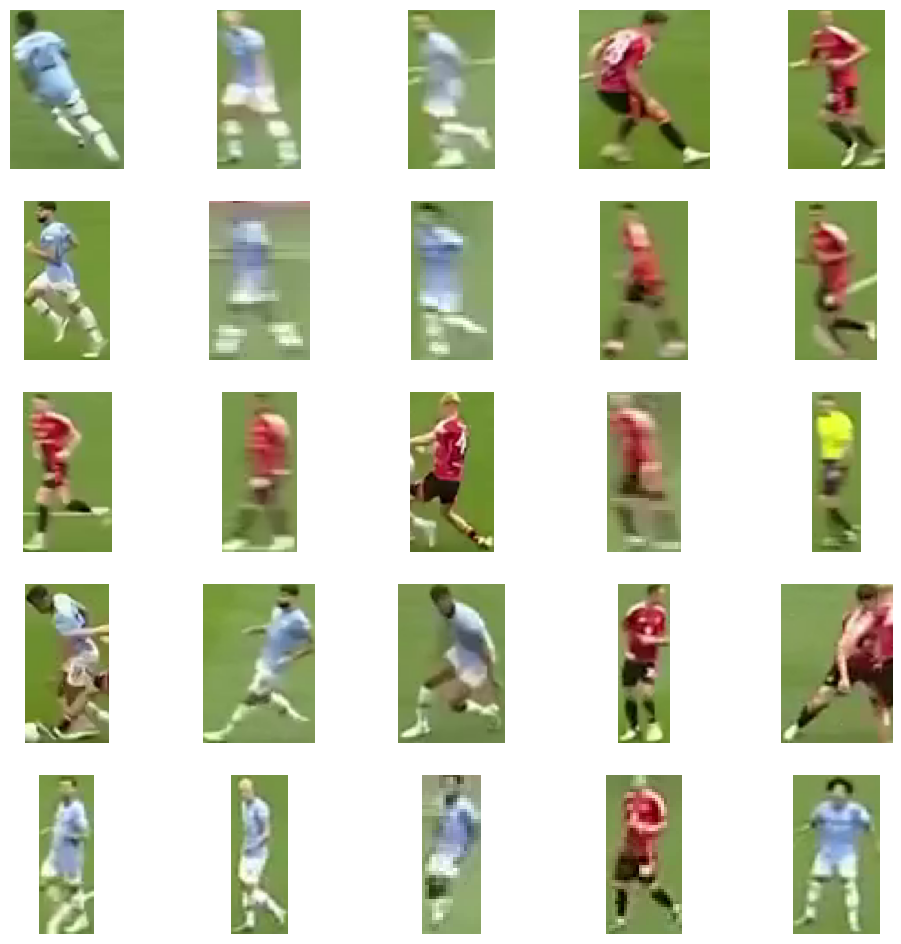

In [97]:
sv.plot_images_grid(crops[:25],grid_size=(5,5))

In [98]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL='google/siglip-base-patch16-224'

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

embedding_processor=AutoProcessor.from_pretrained(SIGLIP_MODEL)
embedding_model=SiglipVisionModel.from_pretrained(SIGLIP_MODEL).to(DEVICE)

In [99]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE=32

crops=[sv.cv2_to_pillow(crop) for (crop) in crops]
batches=chunked(crops,BATCH_SIZE)
data=[]

with torch.no_grad():
  for batch in tqdm(batches,desc="embedding_extraction"):
    inputs=embedding_processor(images=batch, return_tensors='pt').to(DEVICE)
    outputs=embedding_model(**inputs)
    embeddings=torch.mean(outputs.last_hidden_state,dim=1).detach().cpu().numpy()
    data.append(embeddings)
  data=np.concatenate(data)

embedding_extraction: 6it [00:02,  2.82it/s]


In [100]:
data.shape

(163, 768)

In [101]:
import umap
from sklearn.cluster import KMeans

REDUCER=umap.UMAP(n_components=3)
clustering_model=KMeans(n_clusters=2)

In [102]:
projections=REDUCER.fit_transform(data)

In [103]:
projections.shape

(163, 3)

In [104]:
clusters=clustering_model.fit_predict(data)

In [105]:
clusters[:10]

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 1], dtype=int32)

In [108]:
team_0=[
    crop
    for crop,cluster in zip(crops,clusters)
    if cluster==0
]


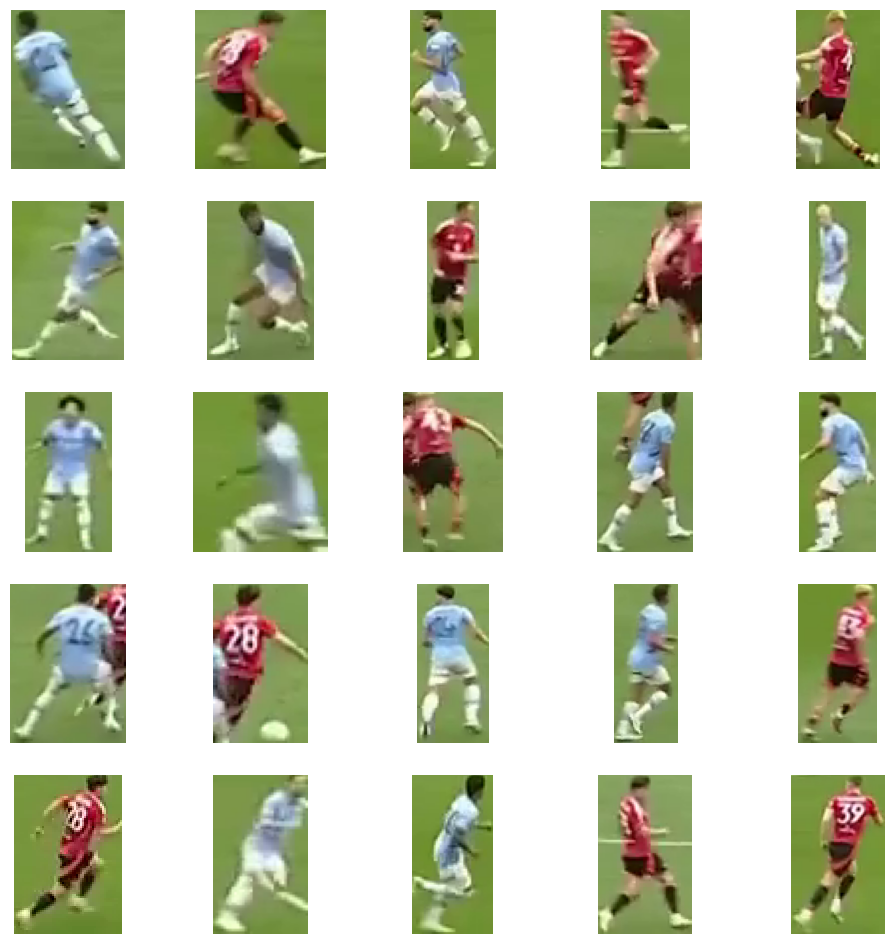

In [109]:
sv.plot_images_grid(team_0[:25],grid_size=(5,5))